**24/01/2021**  
#### This notebook forked @davidtong and edided by Şems Kurtoğlu   
------------------------
Bu 'Jupyter Notebook'  @davidtong alıntılandı ve Şems Kurtoğlu tarafından düzenlendi.

This notebook shows how to train an efficientDet by tensorflow on TPU. 

1. The speed of training on TPU is extremely fast compares to GPU.
    * Using EfficientDet-D4 to train 1 epoch on full datasets only needs 4 minutes. (Batch Size: 32)
    * Using EfficientDet-D7 to train 1 epoch on full datasets only needs 10 minutes (Batch Size: 16)
2. Pure Code
3. Read Datasets from tfrecords
4. Several Dataset Augmentation: Crop / Rotate /  Flip / Mixup / Mosaic  / Hue / Gaussian Noise
5. mAP metric
6. NMS / SoftNMS / Weighted Boxes Fusion
7. Test TTA (4x Flip + Rot90)
8. Search for best iou_theshold and score_threshold from prediction
9. To train, please select TPU as accelerator and turn on internet.
10. To sumbit, please select GPU as accelerator and turn off internet.
11. Todo: Pseudo Labeling

In [1]:
#!pip install efficientnet

In [2]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np
import collections
import math
import string
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from kaggle_datasets import KaggleDatasets
from tqdm import tqdm
import datetime

#import efficientnet.keras as efn 
print(tf.__version__)

2.2.0


In [3]:
def print_time(title):
    print("{0}: {1}".format(title, datetime.datetime.now()))

In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    print('Running on GPU or CPU')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
BATCH_SIZE = (4 * strategy.num_replicas_in_sync) if tpu else 8
NUM_CLASSES = 1
PHI = 4
IMAGE_SIZE = [512, 640, 768, 896, 1024, 1280, 1408, 1536][PHI]
IMAGE_SHAPE_ORG = (1024, 1024, 3) # The shape of images in Tfrecords (H, W, 3)
BOX_SHAPE_ORG = (120, 5) # The shape of boxes in Tfrecords (116: Num of Boxes, 5: x1, y1, x2, y2, classes_idx)

print("Batch Size: {0}".format(BATCH_SIZE))

Batch Size: 32


The code of how generates tfrecords is shown here: https://www.kaggle.com/davidtong/wheat-gen-tf

In [6]:
# Search all Tfrecords

AUTO = tf.data.experimental.AUTOTUNE

TRAIN_GCS_DS_PATH, VALID_GCS_DS_PATH, TRAIN_STEPS_PER_EPOCH, VALID_STEPS_PER_EPOCH = [], [], 0, 0

try:
    GCS_DS_PATH = [KaggleDatasets().get_gcs_path(path) for path in ["wheat-tfrecords" + str(i) for i in range(5)]]
    print(GCS_DS_PATH)
    VALID_GCS_START, VALID_GCS_END = 4, 5 # 80% training datasets, 20% validation datasets
    TRAIN_GCS_DS_PATH = GCS_DS_PATH[0 : VALID_GCS_START] + GCS_DS_PATH[VALID_GCS_END : ]
    VALID_GCS_DS_PATH = GCS_DS_PATH[VALID_GCS_START : VALID_GCS_END]
    TRAIN_STEPS_PER_EPOCH = math.ceil(3373 * len(TRAIN_GCS_DS_PATH) / (len(TRAIN_GCS_DS_PATH) + len(VALID_GCS_DS_PATH)) / BATCH_SIZE)
    VALID_STEPS_PER_EPOCH = math.floor(3373 * len(VALID_GCS_DS_PATH) / (len(TRAIN_GCS_DS_PATH) + len(VALID_GCS_DS_PATH)) / BATCH_SIZE)

    np.random.shuffle(TRAIN_GCS_DS_PATH)
    np.random.shuffle(VALID_GCS_DS_PATH)
    # print(len(TRAIN_GCS_DS_PATH), len(VALID_GCS_DS_PATH), TRAIN_STEPS_PER_EPOCH, VALID_STEPS_PER_EPOCH)
except:
    print("Failed to load tfrecords")

['gs://kds-6f6919fc4ff86dc7abdfd4b5661ee699bfecc01d5e4ccf40660928ae', 'gs://kds-43b8310d8efdf67fbc2fd4946a7226addd7823597af93c7524a365f2', 'gs://kds-49bd96fe0470ca96e90728a82a790719245465ba94ef30e744cc4c6c', 'gs://kds-97f894fd8377387f1819e4679b1f0600b3f306bf7385e00a610edb9c', 'gs://kds-d5c3e1057924c4b9576d4eca07cd00901e733b2f5b3507fb80060bd2']


In [7]:
# Load all tfrecords

class tfrecords_parser:
    def __init__(self):
        self.feature_description_dict = {
            'ndarray' : self._bytes_feature_description, 
            'bytes' : self._bytes_feature_description, 
            'float' : self._float_feature_description,
            'double' : self._float_feature_description, 
            'bool' : self._int64_feature_description,
            'enum' : self._int64_feature_description, 
            'int' : self._int64_feature_description,
            'uint' : self._int64_feature_description
        }
    
    def _bytes_feature_description(self):
        return tf.io.FixedLenFeature([], tf.string)

    def _float_feature_description(self):
        return tf.io.FixedLenFeature([], tf.float)

    def _int64_feature_description(self):
        return tf.io.FixedLenFeature([], tf.int64)
    
    def _decode_example(self, e, example):
        res = []
        for vname in example:
            vtype = type(example[vname]).__name__
            if vtype == "ndarray":
                res.append(tf.reshape(tf.io.decode_raw(e[vname], {
                    'float32' : tf.float32,
                    'float64' : tf.float64,
                    'int32' : tf.int32,
                    'uint16' : tf.uint16,
                    'uint8' : tf.uint8,
                    'int16' : tf.int16,
                    'int8' : tf.int8,
                    'int64' : tf.int64
                }[str(example[vname].dtype)]), example[vname].shape))
            else:
                res.append(tf.cast(e[vname], {
                    'float' : tf.float32,
                    'int' : tf.int32
                }[vtype]))
        return res
    
    def run(self, filename, example):
        reader = tf.data.TFRecordDataset(filename, num_parallel_reads=AUTO)
        feature_description = {}
        for vname in example:
            vtype = type(example[vname]).__name__
            feature_description[vname] = self.feature_description_dict[vtype]()
        reader = reader.map(lambda e: tf.io.parse_single_example(e, feature_description))
        reader = reader.map(lambda e: self._decode_example(e, example))
        return reader

def tfrecords_loader(files_path, ignore_order=True, cache = True):
    @tf.function
    def _normalize(x, y):
        return tf.cast(x, tf.float32) / 255.0, y
    
    def _define_template():
        # Define the template of x and y
        x_template = np.zeros(IMAGE_SHAPE_ORG, np.uint8)
        y_template = np.zeros(BOX_SHAPE_ORG, np.float32)
        return { "x": x_template, "y": y_template }
      
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    datasets = tfrecords_parser().run(tf.io.gfile.glob(files_path), _define_template())
    datasets = datasets.with_options(ignore_order) if ignore_order else datasets
    datasets = datasets.apply(tf.data.experimental.ignore_errors())
    datasets = datasets.cache() if cache else datasets
    datasets = datasets.map(_normalize)
    return datasets


train_datasets, valid_datasets = None, None
try:
    train_datasets = tfrecords_loader([os.path.join(dir_name, '*.tfrecord')  for dir_name in TRAIN_GCS_DS_PATH])
    valid_datasets = tfrecords_loader([os.path.join(dir_name, '*.tfrecord')  for dir_name in VALID_GCS_DS_PATH], ignore_order=False)
except:
    print("Failed to load tfrecords")

In [8]:
# Anchor Box
def get_anchors(image_size):
    all_anchors = []
    grid_size = np.array([8, 16, 32, 64, 128], np.float32)
    anchor_sizes = grid_size * 4.
    anchor_ratios = np.array([0.5, 1, 2], np.float32)
    anchor_scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], np.float32)
    for i in range(5):
        # anchors (1, 9, 4)
        anchors_list = np.zeros((len(anchor_ratios) * len(anchor_scales), 4))
        anchors_list[:, 2] = np.tile(anchor_sizes[i] * anchor_scales, 3) / np.sqrt(np.repeat(anchor_ratios, len(anchor_scales)))
        anchors_list[:, 3] = np.tile(anchor_sizes[i] * anchor_scales, 3) * np.sqrt(np.repeat(anchor_ratios, len(anchor_scales)))
        anchors_list[:, 0::2] -= anchors_list[:, 2:3] * 0.5
        anchors_list[:, 1::2] -= anchors_list[:, 3:4] * 0.5
        anchors_list = np.expand_dims(anchors_list, axis=0)
        
        # shift (K, 1, 4)
        shift_pts = np.arange(grid_size[i] // 2, image_size, grid_size[i], dtype=np.float32)  # [4, 12, 30, ...]
        shift_list = np.zeros((len(shift_pts) ** 2, 4)) # (K, 1, 4)
        shift_list[:,0] = shift_list[:,2] = np.tile(shift_pts, len(shift_pts)) # x1 x2   np.tile (0, 1, 2) => (0, 1, 2, 0, 1, 2, 0, 1, 2)
        shift_list[:,1] = shift_list[:,3] = np.repeat(shift_pts, len(shift_pts)) # y1 y2  np.repeat (0, 1, 2) => (0, 0, 0, 1, 1, 1, 2, 2, 2)
        shift_list = np.expand_dims(shift_list, axis=1)
        
        # merge (K, 9, 4) = > (K * 9, 4)
        all_anchors.append(np.reshape(anchors_list + shift_list, (-1, 4)))
    all_anchors = np.concatenate(all_anchors, axis=0)
    return all_anchors


PRIORS_TF = tf.cast(tf.convert_to_tensor(get_anchors(IMAGE_SIZE)), tf.float32)
PRIORS_CENTER_TF = 0.5 * (PRIORS_TF[:, :2] + PRIORS_TF[:, 2:4])
PRIORS_WH_TF = PRIORS_TF[:, 2:4] - PRIORS_TF[:, :2] + 1
PRIORS_AREA_TF = (PRIORS_TF[:, 2] - PRIORS_TF[:, 0]) * (PRIORS_TF[:, 3] - PRIORS_TF[:, 1]) # (196416)

PRIORS = PRIORS_TF.numpy()
PRIORS_CENTER = PRIORS_CENTER_TF.numpy()
PRIORS_WH = PRIORS_WH_TF.numpy()
PRIORS_AREA = PRIORS_AREA_TF.numpy()

print(PRIORS_TF.shape)

(196416, 4)


In [9]:
@tf.function
def datasets_aug(x, y, batch_size = BATCH_SIZE, hue_en = True, gaussian_noise_en = False, flip_en = True, rotate_en = True, crop_en = True, mosaic_en = True, mixup_en = False):
    # x (Batch Size, H, W, 3)
    # y (Batch Size, N, 5)  x1, y1, x2, y2, class
    
    # Color Aug
    if hue_en:
        x = tf.image.random_hue(x, 0.1)

    # Flip + Rotate + Crop + Gaussian Noise
    x_list, y_list = [], []
    for i in range(batch_size):
        x1, y1, y2 = x[i], y[i][:, 0: 4], y[i][:, 4:] # x, x1y1x2y2, classes_idx
        
        if flip_en: # Flip
            # Flip X
            flip_x = tf.random.uniform([]) >= 0.5
            x1 = tf.cond(flip_x, lambda: tf.image.flip_left_right(x1), lambda: x1)
            y1 = tf.cond(flip_x, lambda: tf.stack([x1.shape[1] - y1[:, 2], y1[:, 1], x1.shape[1] - y1[:, 0], y1[:, 3]], axis=-1), lambda: y1)
            # Flip Y
            flip_y = tf.random.uniform([]) >= 0.5
            x1 = tf.cond(flip_y, lambda: tf.image.flip_up_down(x1), lambda: x1)
            y1 = tf.cond(flip_y, lambda: tf.stack([y1[:, 0], x1.shape[0] - y1[:, 3], y1[:, 2], x1.shape[0] - y1[:, 1]], axis=-1), lambda: y1)
        
        if rotate_en: # Rotate 90
            rotate_90 = tf.random.uniform([]) >= 0.5
            y1 = tf.cond(rotate_90, lambda: tf.stack([y1[:, 1], x1.shape[1] - y1[:, 2], y1[:, 3], x1.shape[1] - y1[:, 0]], axis=-1), lambda: y1)
            x1 = tf.cond(rotate_90, lambda: tf.image.rot90(x1, k=1), lambda: x1) # counter-clock wise 90 degree
            
        if crop_en: # Crop
            #crop = tf.random.uniform([]) >= 0.5
            hw_org = x1.shape[:2]
            hw_expand = tf.cast(tf.cast(hw_org, tf.float32) * tf.random.uniform([], 1., 1.2), tf.int32)
            hw_scale = tf.cast(hw_expand, tf.float32) / tf.cast(hw_org, tf.float32)
            hw_crop = tf.cast(tf.cast(hw_expand - hw_org, tf.float32) * tf.random.uniform([]), tf.int32)

            x1 = tf.image.resize(x1, hw_expand, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            x1 = x1[ hw_crop[0] : hw_crop[0] + hw_org[0], hw_crop[1] : hw_crop[1] + hw_org[1],:]
            x1 = tf.reshape(x1, [hw_org[0], hw_org[1], x1.shape[2]])  # Dynamic Shape to Static Shape

            y1 = y1 * [hw_scale[1], hw_scale[0], hw_scale[1], hw_scale[0]]
            y1 = y1 - [hw_crop[1], hw_crop[0], hw_crop[1], hw_crop[0]]
            y1 = tf.clip_by_value(y1, clip_value_min=[0., 0., 0., 0.], clip_value_max=[hw_org[1], hw_org[0], hw_org[1], hw_org[0]])
        
        if gaussian_noise_en: # Gaussian Noise
            x1 = x1 + ((tf.random.normal(x1.shape, mean=0.0, stddev=1, dtype=tf.float32) - 0.5) * 2) * (10. / 255.)
            x1 = tf.clip_by_value(x1, 0., 1.)
        
        x_list.append(x1)
        y_list.append(tf.concat([y1, y2], axis= -1))
    x, y = tf.stack(x_list, axis=0), tf.stack(y_list, axis=0)
    
    # Mosaic
    
    if mosaic_en:
        x_list, y_list = [], []
        for i in range(batch_size):
            x_center = tf.cast(tf.random.uniform([], 0.2, 0.8) * x.shape[2], tf.int32)
            y_center = tf.cast(tf.random.uniform([], 0.2, 0.8) * x.shape[1], tf.int32)
            
            batch_idx_mosaic0 = i
            batch_idx_mosaic1 = tf.random.uniform([], 0, batch_size, tf.int32)
            batch_idx_mosaic2 = tf.random.uniform([], 0, batch_size, tf.int32)
            batch_idx_mosaic3 = tf.random.uniform([], 0, batch_size, tf.int32)
        
            x1_shape = x.shape[1:]
            x1 = tf.concat([tf.concat([x[batch_idx_mosaic0][:y_center, :x_center, :], 
                                      x[batch_idx_mosaic1][:y_center, x_center:, :]], axis=1), 
                            tf.concat([x[batch_idx_mosaic2][y_center:, :x_center, :], 
                                       x[batch_idx_mosaic3][y_center:, x_center:, :]], axis=1)], axis=0)
            x1 = tf.reshape(x1, x1_shape)
            fmin, fmax = -1e7, 1e7
            y1 = tf.concat([tf.clip_by_value(y[batch_idx_mosaic0,:,:4],
                                            clip_value_min=[fmin, fmin, fmin, fmin], 
                                            clip_value_max=[fmax, fmax, x_center, y_center]),
                           tf.clip_by_value(y[batch_idx_mosaic1,:,:4],
                                            clip_value_min=[x_center, fmin, fmin, fmin],
                                            clip_value_max=[fmax, fmax, fmax, y_center]),
                           tf.clip_by_value(y[batch_idx_mosaic2,:,:4],
                                            clip_value_min=[fmin, y_center, fmin, fmin], 
                                            clip_value_max=[fmax, fmax, x_center, fmax]),
                           tf.clip_by_value(y[batch_idx_mosaic3,:,:4],
                                            clip_value_min=[x_center, y_center, fmin, fmin],
                                            clip_value_max=[fmax, fmax, fmax, fmax]
                                           )], axis=0)
            y2 = tf.concat([y[batch_idx_mosaic0,:, 4:], y[batch_idx_mosaic1,:, 4:], y[batch_idx_mosaic2,:, 4:], y[batch_idx_mosaic3,:, 4:]], axis=0)
            x_list.append(x1)
            y_list.append(tf.concat([y1, y2], axis= -1))
        x, y = tf.stack(x_list, axis=0), tf.stack(y_list, axis=0)
        
    # Mixup
    if mixup_en:
        apply_mix = tf.random.uniform([batch_size]) >= 0.5
        batch_idx = tf.range(batch_size)
        batch_idx_mix = tf.random.shuffle(batch_idx)
        mix_x = tf.gather(x, tf.where(apply_mix, batch_idx_mix, batch_idx))
        mix_y = tf.gather(y, tf.where(apply_mix, batch_idx_mix, batch_idx))
        x = (x + mix_x) / 2
        y = tf.concat([y, mix_y], axis=0)
        
    return x, y

In [10]:
@tf.function
def datasets_encode(x, y, batch_size = BATCH_SIZE, overlap_threshold = 0.5, ignore_threshold = 0.4):
    # x (Batch Size, H, W, 3)
    # y (Batch Size, N, 5)  x1, y1, x2, y2, class

    # resize image
    if IMAGE_SIZE != x.shape[2] or IMAGE_SIZE != x.shape[1]:
        x_scale, y_scale = IMAGE_SIZE / x.shape[2], IMAGE_SIZE / x.shape[1]
        y = y * [x_scale, y_scale, x_scale, y_scale, 1]
        x = tf.image.resize(x, [IMAGE_SIZE, IMAGE_SIZE])
    

    x_list, regression_list, classification_list = [], [], []
    for i in range(batch_size):   # One of Batch
        assignment_x = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        assignment_y = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        assignment_w = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        assignment_h = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        assignment_classes_idx = tf.zeros((PRIORS_TF.shape[0]), tf.float32) + NUM_CLASSES
        assignment_is_obj = tf.zeros((PRIORS_TF.shape[0]), tf.float32)
        

        # filter correct boxes (area > 0)
        priors = tf.expand_dims(PRIORS_TF, axis=0) # (1, 196416, 4)
        box = y[i] # (N, 5)
        indices_for_object = tf.where(tf.math.reduce_all([box[:,4] >= 0, 
                                                          box[:, 2] >= box[:, 0], 
                                                          box[:, 3] >= box[:, 1]], axis=0))
        box = tf.cond(tf.shape(indices_for_object)[0] == 0, 
                        lambda: tf.reshape([0., 0., -1., -1., 0.], (-1, 1, box.shape[-1])),
                        lambda: tf.reshape(tf.gather(box, indices_for_object), (-1, 1, box.shape[-1]))) # (?, 1, 5)
        area_true = tf.maximum(box[:, :, 2] - box[:, :, 0] + 1, 0) * tf.maximum(box[:, :, 3] - box[:, :, 1] + 1, 0) # (?, 1)
        
        # calc iou
        inter_upleft = tf.maximum(priors[:,:, :2], box[:,:,:2])
        inter_botright = tf.minimum(priors[:,:, 2:4], box[:,:,2:4])
        inter_wh = inter_botright - inter_upleft + 1
        inter_wh = tf.maximum(inter_wh, 0)  # (?, 196416, 2)
        inter = inter_wh[:, :, 0] * inter_wh[:, :, 1] #(?, 196416)
        area_gt = tf.expand_dims(PRIORS_AREA_TF, axis=0) # (1, 196416)
        union = area_true + area_gt - inter # (?, 196416)
        iou = inter / union # (?, 196416)
        iou_max = tf.math.reduce_max(iou, axis=0) # (196416)
        iou_max_idxs = tf.math.argmax(iou, axis=0) # (196416)
        
        # ignore box
        ignore_mask = tf.math.logical_and(iou_max > ignore_threshold, iou_max < overlap_threshold) # (196416)
        assignment_is_obj = tf.where(ignore_mask, -1., assignment_is_obj)
        
        # object box
        assign_mask = tf.math.logical_or(iou_max > overlap_threshold, iou_max == tf.math.maximum(tf.math.reduce_max(iou_max), 1e-7)) # (196416)
        box_best = tf.gather(tf.squeeze(box, axis=1), iou_max_idxs, axis=0) # (?, 5) + (196416) => (196416, 5)
        assignment_is_obj = tf.where(assign_mask, 1., assignment_is_obj)
        assignment_classes_idx = tf.where(assign_mask, box_best[:, 4], assignment_classes_idx)
        
        box_center = 0.5 * (box_best[:,:2] + box_best[:,2:4]) #  (196416, 2)
        box_wh = box_best[:,2:4] - box_best[:,:2] + 1 #  (196416, 2)
        assigned_xy = (box_center - PRIORS_CENTER_TF) / PRIORS_WH_TF #  (196416, 2)
        assigned_wh = tf.math.log(box_wh / PRIORS_WH_TF) #  (196416, 2)
        assignment_x = tf.where(assign_mask, assigned_xy[:, 0], assignment_x)
        assignment_y = tf.where(assign_mask, assigned_xy[:, 1], assignment_y)
        assignment_w = tf.where(assign_mask, assigned_wh[:, 0], assignment_w)
        assignment_h = tf.where(assign_mask, assigned_wh[:, 1], assignment_h)
            
        x_list.append(x[i])
        regression_list.append(tf.stack([
            assignment_x, assignment_y, 
            assignment_w, assignment_h, 
            assignment_is_obj], axis=-1))

        classification_list.append(tf.concat([
            tf.one_hot(tf.cast(assignment_classes_idx, tf.int32), NUM_CLASSES + 1)[:, 0:-1], 
            tf.reshape(assignment_is_obj, (-1, 1))], axis=-1))
        
    x_list = tf.stack(x_list, axis=0)
    regression_list = tf.stack(regression_list, axis=0)
    classification_list = tf.stack(classification_list, axis=0)
    
    print(x_list.shape, regression_list.shape, classification_list.shape)
    
    return x_list, (regression_list, classification_list)

In [11]:
def boxes_decode(regression, classification):
    regression = regression[:, :, 0:4]  # (Batch Size, 196416, 4)
    classification = classification[:, :, 0:NUM_CLASSES] # (Batch Size, 196416, NUM_CLASSES)
    tx = (regression[:,:,0] * PRIORS_WH[:, 0] + PRIORS_CENTER[:, 0]) # (Batch Size, 196416)
    ty = (regression[:,:,1] * PRIORS_WH[:, 1] + PRIORS_CENTER[:, 1]) # (Batch Size, 196416)
    tw = np.exp(regression[:,:,2]) * PRIORS_WH[:, 0] # (Batch Size, 196416)
    th = np.exp(regression[:,:,3]) * PRIORS_WH[:, 1] # (Batch Size, 196416)
    regression = np.stack([tx - tw / 2, ty - th / 2, tx + tw / 2, ty + th / 2], axis=-1) # (Batch Size, 196416, 4) 
    return regression, classification

def boxes_ensemble(regression, classification, iou_threshold=0.5, score_threshold=0.5, method='wbf', sigma=0.5):
    batch_obj_box_list = []
    for i in range(regression.shape[0]):
        boxes, scores, labels = regression[i], np.expand_dims(np.amax(classification[i], axis=-1), axis=-1), np.expand_dims(np.argmax(classification[i], axis=-1), axis=-1)
        # Boxes ensemble
        valid_idxs = tf.where(scores >=score_threshold)[:,0]
        boxes, scores, labels = np.take(boxes, valid_idxs, axis=0), np.take(scores, valid_idxs, axis=0), np.take(labels, valid_idxs, axis=0)
        areas = (np.maximum(boxes[:, 2] - boxes[:, 0] + 1, 0.0) * np.maximum(boxes[:, 3] - boxes[:, 1] + 1, 0.0))[:, None]
        dets = np.concatenate((boxes, scores, labels, areas), axis=1) # (?, 7)
        if method == 'wbf':
            wboxes, w_boxes_score = np.zeros((0, 7)), [] # x1, y2, x2, y2, score_sum, label, area
            for i in np.argsort(-dets[:,4]):
                if wboxes.shape[0] != 0:
                    inter = np.maximum(np.minimum(dets[i, 2], wboxes[:, 2]) - np.maximum(dets[i, 0], wboxes[:, 0]) + 1, 0.0) * \
                            np.maximum(np.minimum(dets[i, 3], wboxes[:, 3]) - np.maximum(dets[i, 1], wboxes[:, 1]) + 1, 0.0)
                    iou = inter / (dets[i, -1] + wboxes[:, -1] - inter)
                    iou = np.where(wboxes[:, 5] == dets[i, 5], iou, 0)
                    best_iou_idx = np.argmax(iou)
                    if iou[best_iou_idx] >= iou_threshold:
                        best_wboxes = wboxes[best_iou_idx]
                        wcoord, wscores = best_wboxes[:4], best_wboxes[4]
                        dcoord, dscore, dlabel = dets[i, :4], dets[i, 4], dets[i, 5]
                        ncoord, nscore = (wcoord * wscores + dcoord * dscore) / (wscores + dscore), (wscores + dscore)
                        wboxes[best_iou_idx] = [ncoord[0], ncoord[1], ncoord[2], ncoord[3], nscore, dlabel, (ncoord[2] - ncoord[0] + 1) * (ncoord[3] - ncoord[1] + 1)]
                        w_boxes_score[best_iou_idx].append(dscore)
                        continue
                wboxes = np.concatenate((wboxes, dets[i:i+1]), axis=0)
                w_boxes_score.append([dets[i, 4]])
            for i in range(len(w_boxes_score)): # Update Score
                wboxes[i, 4] = np.mean(w_boxes_score[i]) * min(1, len(w_boxes_score[i])) / 1
            batch_obj_box_list.append(wboxes[:, : -1])
        elif (method == 'linear' or method == 'gaussian' or method == 'nms'):
            retained_box = []
            while dets.size > 0:
                max_idx = np.argmax(dets[:, 4], axis=0)
                dets[[0, max_idx], :] = dets[[max_idx, 0], :]        
                retained_box.append(dets[0, :-1])
                inter = np.maximum(np.minimum(dets[0, 2], dets[1:, 2]) - np.maximum(dets[0, 0], dets[1:, 0]) + 1, 0.0) * \
                        np.maximum(np.minimum(dets[0, 3], dets[1:, 3]) - np.maximum(dets[0, 1], dets[1:, 1]) + 1, 0.0)
                iou = inter / (dets[0, -1] + dets[1:, -1] - inter)
                iou = np.where(dets[0, 5] == dets[1:, 5], iou, 0)
                weight = None
                if method == 'linear':
                    weight = np.ones_like(iou)
                    weight[iou > iou_threshold] -= iou[iou > iou_threshold]
                elif method == 'gaussian':
                    weight = np.exp(-(iou * iou) / sigma)
                else:  # traditional nms
                    weight = np.ones_like(iou)
                    weight[iou > iou_threshold] = 0
                dets[1:, 4] *= weight
                retained_idx = np.where(dets[1:, 4] >= score_threshold)[0]
                dets = dets[retained_idx + 1, :]
            batch_obj_box_list.append(np.vstack(retained_box))
    return batch_obj_box_list

def datasets_decode(regression, classification, iou_threshold = 0.5, score_threshold=0.5, method='wbf'):
    # x (Batch Size, H, W, 3)
    regression, classification = boxes_decode(regression, classification)
    batch_obj_box_list = boxes_ensemble(regression, classification, iou_threshold=iou_threshold, score_threshold=score_threshold, method=method)
    return batch_obj_box_list

In [12]:
# mAP
def metric_mAP(obj_info_true, obj_info_pred, iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    if len(iou_thresholds) == 0:
        return 0.
    batch_size = len(obj_info_true)
    precision_list = []

    for i in range(batch_size):
        y_true, y_pred = obj_info_true[i], obj_info_pred[i] # (K1, 6) (K2, 6)
        # sort by scores
        y_true = y_true[np.argsort(- y_true[:,4])] #tf.gather
        y_pred = y_pred[np.argsort(- y_pred[:,4])]
        area_true = (y_true[:, 2] - y_true[:, 0] + 1) * (y_true[:, 3] - y_true[:, 1] + 1)  # (K1)
        area_pred = (y_pred[:, 2] - y_pred[:, 0] + 1) * (y_pred[:, 3] - y_pred[:, 1] + 1) # (K2)
        for iou_threshold in iou_thresholds:
            tp, fp, true_cnt, pred_cnt = 0, 0, y_true.shape[0], y_pred.shape[0]
            dismatched_list = np.arange(true_cnt) # 0, 1, 2, 3
            for j in range(pred_cnt):
                # calc iou
                inter_upleft = np.maximum(y_true[:,:2], y_pred[j,:2]) # (K1, 2) + (2) => (K1, 2)
                inter_botright = np.minimum(y_true[:,2:4], y_pred[j,2:4]) # (K1, 2) + (2) => (K1, 2)
                inter_wh = inter_botright - inter_upleft + 1
                inter_wh = np.maximum(inter_wh, 0)  # (K1, 2)
                inter = inter_wh[:, 0] * inter_wh[:, 1] #(K1)
                iou = inter / (area_true + area_pred[j] - inter) # (K1)
                iou = np.where(np.logical_and(dismatched_list >= 0, y_pred[j,5] == y_true[:,5]), iou, 0.)
                iou_matched = (np.amax(iou) >= iou_threshold)
                # update
                if (iou_matched == True):
                    tp += 1
                    dismatched_list[np.argmax(iou)] = -1
                else:
                    fp += 1
            fn = np.count_nonzero(dismatched_list >= 0)
            precision_list.append(tp / (tp + fp + fn))
    # Filter Nan
    precision_list = np.array(precision_list)
    precision_list = precision_list[np.where(np.isnan(precision_list) == False)]
    return np.mean(precision_list)

In [13]:
def visualize_decode(batch_x, batch_obj_info, display_cnt = 4):
    batch_x = np.array(batch_x)
    for i in range(batch_x.shape[0])[0:display_cnt]:
        img, obj_info = batch_x[i], batch_obj_info[i]
        for j in range(obj_info.shape[0]):
            tx1, ty1, tx2, ty2, score, classes_idx = obj_info[j]
            tx1, ty1, tx2, ty2, score, classes_idx =  int(tx1), int(ty1), int(tx2), int(ty2), round(score, 1), int(classes_idx)
            cv2.rectangle(img, (tx1, ty1), (tx2, ty2), (127, 0, 127), 5)
            cv2.putText(img, str(score), (tx1, ty1), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 127, 127), 2, cv2.LINE_AA)
        plt.figure(i)
        plt.figure(figsize=(6, 6))
        plt.axis('off')
        plt.title("{0} objects".format(obj_info.shape[0]))
        plt.imshow(img)

In [14]:
train_dataset_encode, valid_dataset_encode = [], []
if (train_datasets is not None) and (valid_datasets is not None):
    train_dataset_encode = train_datasets.repeat().shuffle(256).batch(BATCH_SIZE)
    train_dataset_encode = train_dataset_encode.map(datasets_aug, num_parallel_calls=AUTO)
    train_dataset_encode = train_dataset_encode.map(datasets_encode, num_parallel_calls=AUTO).prefetch(AUTO)

    valid_dataset_encode = valid_datasets.repeat().batch(BATCH_SIZE)
    valid_dataset_encode = valid_dataset_encode.map(datasets_encode, num_parallel_calls=AUTO).prefetch(AUTO)
else:
    print("Failed to load tfrecors")

(32, 1024, 1024, 3) (32, 196416, 5) (32, 196416, 2)
(32, 1024, 1024, 3) (32, 196416, 5) (32, 196416, 2)


mAP: 1.0


<Figure size 432x288 with 0 Axes>

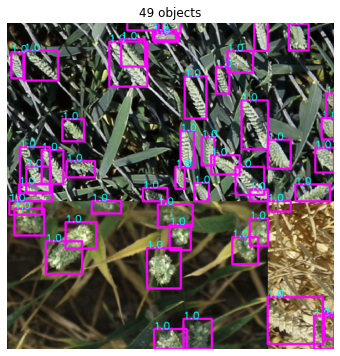

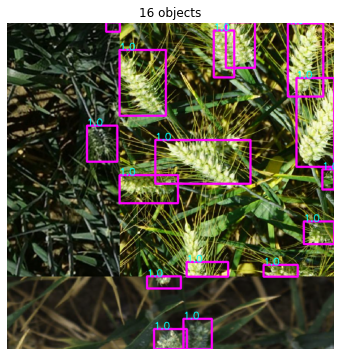

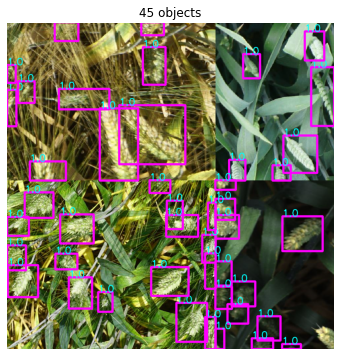

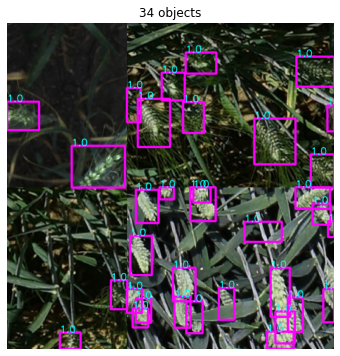

In [15]:
for batch_x, (batch_regression, batch_classification) in train_dataset_encode:
    batch_obj_info = datasets_decode(batch_regression, batch_classification, iou_threshold = 0.99, score_threshold=1.0)
    print("mAP: {0}".format(metric_mAP(batch_obj_info, batch_obj_info)))
    visualize_decode(batch_x, batch_obj_info)
    break

The code of building EfficientDet is copied from https://github.com/bubbliiiing/efficientdet-keras

In [16]:
def EfficientNetBN(n, input_tensor=None, input_shape=None, **kwargs):
    CONV_KERNEL_INITIALIZER = {
        'class_name': 'VarianceScaling',
        'config': {
            'scale': 2.0,
            'mode': 'fan_out',
            # EfficientNet actually uses an untruncated normal distribution for
            # initializing conv layers, but keras.initializers.VarianceScaling use
            # a truncated distribution.
            # We decided against a custom initializer for better serializability.
            'distribution': 'normal'
        }
    }

    def get_swish():
        def swish(x):
            return x * tf.math.sigmoid(x)
        return swish


    def get_dropout():
        class FixedDropout(layers.Dropout):
            def _get_noise_shape(self, inputs):
                if self.noise_shape is None:
                    return self.noise_shape
                symbolic_shape = tf.shape(inputs)
                noise_shape = [symbolic_shape[axis] if (shape is None) else shape for axis, shape in enumerate(self.noise_shape)]
                return tuple(noise_shape)
        return FixedDropout


    def round_filters(filters, width_coefficient, depth_divisor):
        filters *= width_coefficient
        new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
        new_filters = max(depth_divisor, new_filters)
        if new_filters < 0.9 * filters:
            new_filters += depth_divisor
        return int(new_filters)


    def round_repeats(repeats, depth_coefficient):
        return int(math.ceil(depth_coefficient * repeats))


    def mb_conv_block(inputs, block_args, activation, drop_rate=None, prefix='', freeze_bn=False):
        has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
        bn_axis = 3 

        Dropout = get_dropout()

        filters = block_args.input_filters * block_args.expand_ratio
        if block_args.expand_ratio != 1:
            x = layers.Conv2D(filters, 1, padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'expand_conv')(inputs)
            x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'expand_bn')(x)
            x = layers.Activation(activation, name=prefix + 'expand_activation')(x)
        else:
            x = inputs

        # Depthwise Convolution
        x = layers.DepthwiseConv2D(block_args.kernel_size, strides=block_args.strides, padding='same', use_bias=False, depthwise_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'dwconv')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'bn')(x)
        x = layers.Activation(activation, name=prefix + 'activation')(x)

        # Squeeze and Excitation phase
        if has_se:
            num_reduced_filters = max(1, int(block_args.input_filters * block_args.se_ratio))
            se_tensor = layers.GlobalAveragePooling2D(name=prefix + 'se_squeeze')(x)

            target_shape = (1, 1, filters) if backend.image_data_format() == 'channels_last' else (filters, 1, 1)
            se_tensor = layers.Reshape(target_shape, name=prefix + 'se_reshape')(se_tensor)
            se_tensor = layers.Conv2D(num_reduced_filters, 1, activation=activation, padding='same', use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'se_reduce')(se_tensor)
            se_tensor = layers.Conv2D(filters, 1, activation='sigmoid', padding='same', use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'se_expand')(se_tensor)
            if backend.backend() == 'theano':
                pattern = ([True, True, True, False] if (backend.image_data_format() == 'channels_last') else [True, False, True, True])
                se_tensor = layers.Lambda(lambda x: backend.pattern_broadcast(x, pattern), name=prefix + 'se_broadcast')(se_tensor)
            x = layers.multiply([x, se_tensor], name=prefix + 'se_excite')

        # Output phase
        x = layers.Conv2D(block_args.output_filters, 1, padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name=prefix + 'project_conv')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'project_bn')(x)
        if block_args.id_skip and all(s == 1 for s in block_args.strides) and block_args.input_filters == block_args.output_filters:
            if drop_rate and (drop_rate > 0):
                x = Dropout(drop_rate, noise_shape=(None, 1, 1, 1), name=prefix + 'drop')(x)
            x = layers.add([x, inputs], name=prefix + 'add')
        return x


    def EfficientNet(width_coefficient, depth_coefficient, drop_connect_rate=0.2, depth_divisor=8, input_tensor=None, input_shape=None, freeze_bn=False, **kwargs):
        BlockArgs = collections.namedtuple('BlockArgs', [
            'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
            'expand_ratio', 'id_skip', 'strides', 'se_ratio'
        ])
        blocks_args = [
            BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16, expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
            BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
            BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
            BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
            BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112, expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
            BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
            BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320, expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
        ]
        
        features = []

        img_input = layers.Input(shape=input_shape) if (input_tensor is None) else (input_tensor)

        bn_axis = 3 
        activation = get_swish(**kwargs)

        # Build stem
        x = img_input
        x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name='stem_conv')(x)
        x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
        x = layers.Activation(activation, name='stem_activation')(x)
        # Build blocks
        num_blocks_total = sum(block_args.num_repeat for block_args in blocks_args)
        block_num = 0
        for idx, block_args in enumerate(blocks_args):
            assert block_args.num_repeat > 0
            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, width_coefficient, depth_divisor),
                output_filters=round_filters(block_args.output_filters, width_coefficient, depth_divisor),
                num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))

            # The first block needs to take care of stride and filter size increase.
            drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
            x = mb_conv_block(x, block_args, activation=activation, drop_rate=drop_rate, prefix='block{}a_'.format(idx + 1), freeze_bn=freeze_bn)
            block_num += 1
            if block_args.num_repeat > 1:
                # pylint: disable=protected-access
                block_args = block_args._replace(
                    input_filters=block_args.output_filters, strides=[1, 1])
                # pylint: enable=protected-access
                for bidx in range(block_args.num_repeat - 1):
                    drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                    block_prefix = 'block{}{}_'.format(idx + 1, string.ascii_lowercase[bidx + 1])
                    x = mb_conv_block(x, block_args, activation=activation, drop_rate=drop_rate, prefix=block_prefix, freeze_bn=freeze_bn)
                    block_num += 1
            if idx < len(blocks_args) - 1 and blocks_args[idx + 1].strides[0] == 2:
                features.append(x)
            elif idx == len(blocks_args) - 1:
                features.append(x)
        return features

    
    parms = [
        { "width_coefficient" : 1.0, "depth_coefficient" : 1.0, "default_resolution" : 224},
        { "width_coefficient" : 1.0, "depth_coefficient" : 1.1, "default_resolution" : 240},
        { "width_coefficient" : 1.1, "depth_coefficient" : 1.2, "default_resolution" : 260},
        { "width_coefficient" : 1.2, "depth_coefficient" : 1.4, "default_resolution" : 300},
        { "width_coefficient" : 1.4, "depth_coefficient" : 1.8, "default_resolution" : 380},
        { "width_coefficient" : 1.6, "depth_coefficient" : 2.2, "default_resolution" : 456},
        { "width_coefficient" : 1.8, "depth_coefficient" : 2.6, "default_resolution" : 528},
        { "width_coefficient" : 2.0, "depth_coefficient" : 3.1, "default_resolution" : 600},
    ][n]
    return EfficientNet(parms['width_coefficient'], parms['depth_coefficient'], input_tensor=input_tensor, input_shape=input_shape, **kwargs)

#print(EfficientNetBN(7, input_shape=(600, 600, 3)))

In [17]:
MOMENTUM = 0.99
EPSILON = 1e-3

class wBiFPNAdd(layers.Layer):
    def __init__(self, epsilon=1e-4, **kwargs):
        super(wBiFPNAdd, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        num_in = len(input_shape)
        self.w = self.add_weight(name=self.name, shape=(num_in,), initializer=initializers.constant(1 / num_in), trainable=True, dtype=tf.float32)

    def call(self, inputs, **kwargs):
        w = activations.relu(self.w)
        x = tf.reduce_sum([w[i] * inputs[i] for i in range(len(inputs))], axis=0)
        x = x / (tf.reduce_sum(w) + self.epsilon)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def get_config(self):
        config = super(wBiFPNAdd, self).get_config()
        config.update({ 'epsilon': self.epsilon })
        return config
    
    
def SeparableConvBlock(num_channels, kernel_size, strides, name, freeze_bn=False):
    f1 = layers.SeparableConv2D(num_channels, kernel_size=kernel_size, strides=strides, padding='same',
                                use_bias=True, name=f'{name}/conv')
    f2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name=f'{name}/bn')
    return lambda *args, **kwargs: f2(f1(*args, **kwargs))


def build_wBiFPN(features, num_channels, id, freeze_bn=False):
    if id == 0:
        _, _, C3, C4, C5 = features
        # 第一次BIFPN需要 下采样 与 降通道 获得 p3_in p4_in p5_in p6_in p7_in
        #-----------------------------下采样 与 降通道----------------------------#
        P3_in = C3
        P3_in = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                              name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/conv2d')(P3_in)
        P3_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                          name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/bn')(P3_in)

        P4_in = C4
        P4_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/conv2d')(P4_in)
        P4_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/bn')(P4_in_1)
        P4_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/conv2d')(P4_in)
        P4_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/bn')(P4_in_2)

        P5_in = C5
        P5_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/conv2d')(P5_in)
        P5_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/bn')(P5_in_1)
        P5_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/conv2d')(P5_in)
        P5_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/bn')(P5_in_2)

        P6_in = layers.Conv2D(num_channels, kernel_size=1, padding='same', name='resample_p6/conv2d')(C5)
        P6_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name='resample_p6/bn')(P6_in)
        P6_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p6/maxpool')(P6_in)

        P7_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p7/maxpool')(P6_in)
        #-------------------------------------------------------------------------#

        #--------------------------构建BIFPN的上下采样循环-------------------------#
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode0/add')([P6_in, P7_U])
        P6_td = layers.Activation(lambda x: tf.nn.swish(x))(P6_td)
        P6_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode0/op_after_combine5')(P6_td)
        
        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode1/add')([P5_in_1, P6_U])
        P5_td = layers.Activation(lambda x: tf.nn.swish(x))(P5_td)
        P5_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode1/op_after_combine6')(P5_td)

        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode2/add')([P4_in_1, P5_U])
        P4_td = layers.Activation(lambda x: tf.nn.swish(x))(P4_td)
        P4_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode2/op_after_combine7')(P4_td)

        P4_U = layers.UpSampling2D()(P4_td)
        P3_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode3/add')([P3_in, P4_U])
        P3_out = layers.Activation(lambda x: tf.nn.swish(x))(P3_out)
        P3_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode3/op_after_combine8')(P3_out)

        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode4/add')([P4_in_2, P4_td, P3_D])
        P4_out = layers.Activation(lambda x: tf.nn.swish(x))(P4_out)
        P4_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode4/op_after_combine9')(P4_out)

        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode5/add')([P5_in_2, P5_td, P4_D])
        P5_out = layers.Activation(lambda x: tf.nn.swish(x))(P5_out)
        P5_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode5/op_after_combine10')(P5_out)

        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode6/add')([P6_in, P6_td, P5_D])
        P6_out = layers.Activation(lambda x: tf.nn.swish(x))(P6_out)
        P6_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode6/op_after_combine11')(P6_out)

        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode7/add')([P7_in, P6_D])
        P7_out = layers.Activation(lambda x: tf.nn.swish(x))(P7_out)
        P7_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode7/op_after_combine12')(P7_out)

    else:
        P3_in, P4_in, P5_in, P6_in, P7_in = features
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode0/add')([P6_in, P7_U])
        P6_td = layers.Activation(lambda x: tf.nn.swish(x))(P6_td)
        P6_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode0/op_after_combine5')(P6_td)

        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode1/add')([P5_in, P6_U])
        P5_td = layers.Activation(lambda x: tf.nn.swish(x))(P5_td)
        P5_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode1/op_after_combine6')(P5_td)

        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode2/add')([P4_in, P5_U])
        P4_td = layers.Activation(lambda x: tf.nn.swish(x))(P4_td)
        P4_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode2/op_after_combine7')(P4_td)

        P4_U = layers.UpSampling2D()(P4_td)
        P3_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode3/add')([P3_in, P4_U])
        P3_out = layers.Activation(lambda x: tf.nn.swish(x))(P3_out)
        P3_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode3/op_after_combine8')(P3_out)

        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode4/add')([P4_in, P4_td, P3_D])
        P4_out = layers.Activation(lambda x: tf.nn.swish(x))(P4_out)
        P4_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode4/op_after_combine9')(P4_out)

        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode5/add')([P5_in, P5_td, P4_D])
        P5_out = layers.Activation(lambda x: tf.nn.swish(x))(P5_out)
        P5_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode5/op_after_combine10')(P5_out)

        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode6/add')([P6_in, P6_td, P5_D])
        P6_out = layers.Activation(lambda x: tf.nn.swish(x))(P6_out)
        P6_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode6/op_after_combine11')(P6_out)

        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode7/add')([P7_in, P6_D])
        P7_out = layers.Activation(lambda x: tf.nn.swish(x))(P7_out)
        P7_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode7/op_after_combine12')(P7_out)
    return [P3_out, P4_out, P5_out, P6_out, P7_out]

def build_BiFPN(features, num_channels, id, freeze_bn=False):
    if id == 0:
        # 第一次BIFPN需要 下采样 与 降通道 获得 p3_in p4_in p5_in p6_in p7_in
        #-----------------------------下采样 与 降通道----------------------------#
        _, _, C3, C4, C5 = features
        P3_in = C3
        P3_in = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                              name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/conv2d')(P3_in)
        P3_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                          name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/bn')(P3_in)

        P4_in = C4
        P4_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/conv2d')(P4_in)
        P4_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/bn')(P4_in_1)
        P4_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/conv2d')(P4_in)
        P4_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/bn')(P4_in_2)

        P5_in = C5
        P5_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/conv2d')(P5_in)
        P5_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/bn')(P5_in_1)
        P5_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/conv2d')(P5_in)
        P5_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/bn')(P5_in_2)

        P6_in = layers.Conv2D(num_channels, kernel_size=1, padding='same', name='resample_p6/conv2d')(C5)
        P6_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name='resample_p6/bn')(P6_in)
        P6_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p6/maxpool')(P6_in)

        P7_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p7/maxpool')(P6_in)
        #-------------------------------------------------------------------------#

        #--------------------------构建BIFPN的上下采样循环-------------------------#
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode0/add')([P6_in, P7_U])
        P6_td = layers.Activation(lambda x: tf.nn.swish(x))(P6_td)
        P6_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode0/op_after_combine5')(P6_td)

        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode1/add')([P5_in_1, P6_U])
        P5_td = layers.Activation(lambda x: tf.nn.swish(x))(P5_td)
        P5_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode1/op_after_combine6')(P5_td)

        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode2/add')([P4_in_1, P5_U])
        P4_td = layers.Activation(lambda x: tf.nn.swish(x))(P4_td)
        P4_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode2/op_after_combine7')(P4_td)

        P4_U = layers.UpSampling2D()(P4_td)
        P3_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode3/add')([P3_in, P4_U])
        P3_out = layers.Activation(lambda x: tf.nn.swish(x))(P3_out)
        P3_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode3/op_after_combine8')(P3_out)

        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode4/add')([P4_in_2, P4_td, P3_D])
        P4_out = layers.Activation(lambda x: tf.nn.swish(x))(P4_out)
        P4_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode4/op_after_combine9')(P4_out)

        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode5/add')([P5_in_2, P5_td, P4_D])
        P5_out = layers.Activation(lambda x: tf.nn.swish(x))(P5_out)
        P5_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode5/op_after_combine10')(P5_out)

        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode6/add')([P6_in, P6_td, P5_D])
        P6_out = layers.Activation(lambda x: tf.nn.swish(x))(P6_out)
        P6_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode6/op_after_combine11')(P6_out)

        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode7/add')([P7_in, P6_D])
        P7_out = layers.Activation(lambda x: tf.nn.swish(x))(P7_out)
        P7_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode7/op_after_combine12')(P7_out)

    else:
        P3_in, P4_in, P5_in, P6_in, P7_in = features
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode0/add')([P6_in, P7_U])
        P6_td = layers.Activation(lambda x: tf.nn.swish(x))(P6_td)
        P6_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode0/op_after_combine5')(P6_td)

        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode1/add')([P5_in, P6_U])
        P5_td = layers.Activation(lambda x: tf.nn.swish(x))(P5_td)
        P5_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode1/op_after_combine6')(P5_td)

        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = layers.Add(name=f'fpn_cells/cell_{id}/fnode2/add')([P4_in, P5_U])
        P4_td = layers.Activation(lambda x: tf.nn.swish(x))(P4_td)
        P4_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode2/op_after_combine7')(P4_td)

        P4_U = layers.UpSampling2D()(P4_td)
        P3_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode3/add')([P3_in, P4_U])
        P3_out = layers.Activation(lambda x: tf.nn.swish(x))(P3_out)
        P3_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode3/op_after_combine8')(P3_out)

        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode4/add')([P4_in, P4_td, P3_D])
        P4_out = layers.Activation(lambda x: tf.nn.swish(x))(P4_out)
        P4_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode4/op_after_combine9')(P4_out)

        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode5/add')([P5_in, P5_td, P4_D])
        P5_out = layers.Activation(lambda x: tf.nn.swish(x))(P5_out)
        P5_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode5/op_after_combine10')(P5_out)

        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode6/add')([P6_in, P6_td, P5_D])
        P6_out = layers.Activation(lambda x: tf.nn.swish(x))(P6_out)
        P6_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode6/op_after_combine11')(P6_out)

        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = layers.Add(name=f'fpn_cells/cell_{id}/fnode7/add')([P7_in, P6_D])
        P7_out = layers.Activation(lambda x: tf.nn.swish(x))(P7_out)
        P7_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode7/op_after_combine12')(P7_out)
    return [P3_out, P4_out, P5_out, P6_out, P7_out]

class PriorProbability(initializers.Initializer):
    """ Apply a prior probability to the weights.
    """
    def __init__(self, probability=0.01):
        self.probability = probability

    def get_config(self):
        return { 'probability': self.probability }

    def __call__(self, shape, dtype=None):
        # set bias to -log((1 - p)/p) for foreground
        result = np.ones(shape) * -math.log((1 - self.probability) / self.probability)

        return result

    
class BoxNet(layers.Layer):
    def __init__(self, width, depth, num_anchors=9, freeze_bn=False, name='box_net', **kwargs):
        super().__init__()
        
        self.width = width
        self.depth = depth
        self.num_anchors = num_anchors
        options = {
            'kernel_size': 3,
            'strides': 1,
            'padding': 'same',
            'bias_initializer': 'zeros',
            'depthwise_initializer': initializers.VarianceScaling(),
            'pointwise_initializer': initializers.VarianceScaling(),
        }

        self.convs = [layers.SeparableConv2D(filters=width, name=f'{name}/box-{i}', **options) for i in range(depth)]
        self.head = layers.SeparableConv2D(filters=num_anchors * 4, name=f'{name}/box-predict', **options)

        self.bns = [
            [layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name=f'{name}/box-{i}-bn-{j}') for j in
             range(3, 8)]
            for i in range(depth)]

        self.relu = layers.Lambda(lambda x: tf.nn.swish(x))
        self.reshape = layers.Reshape((-1, 4))

    def call(self, inputs):
        feature, level = inputs
        for i in range(self.depth):
            feature = self.convs[i](feature)
            feature = self.bns[i][level](feature)
            feature = self.relu(feature)
        outputs = self.head(feature)
        outputs = self.reshape(outputs)
        return outputs


class ClassNet(layers.Layer):
    def __init__(self, width, depth, num_classes=20, num_anchors=9, freeze_bn=False, name='class_net', **kwargs):
        super().__init__()
        
        self.width = width
        self.depth = depth
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        options = {
            'kernel_size': 3,
            'strides': 1,
            'padding': 'same',
            'depthwise_initializer': initializers.VarianceScaling(),
            'pointwise_initializer': initializers.VarianceScaling(),
        }

        self.convs = [layers.SeparableConv2D(filters=width, bias_initializer='zeros', name=f'{name}/class-{i}', **options) for i in range(depth)]
        self.head = layers.SeparableConv2D(filters=num_classes * num_anchors, bias_initializer=PriorProbability(probability=0.01), name=f'{name}/class-predict', **options)
        self.bns = [[layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name=f'{name}/class-{i}-bn-{j}') for j in range(3, 8)] for i in range(depth)]
        self.relu = layers.Lambda(lambda x: tf.nn.swish(x))
        self.reshape = layers.Reshape((-1, num_classes))
        self.activation = layers.Activation('sigmoid')

    def call(self, inputs):
        feature, level = inputs
        for i in range(self.depth):
            feature = self.convs[i](feature)
            feature = self.bns[i][level](feature)
            feature = self.relu(feature)
        outputs = self.head(feature)
        outputs = self.reshape(outputs)
        outputs = self.activation(outputs)
        return outputs

def Efficientdet(phi, num_classes=20, num_anchors=9, freeze_bn=False):
    assert phi in range(8)
    fpn_num_filters = [64, 88, 112, 160, 224, 288, 384,384]
    fpn_cell_repeats = [3, 4, 5, 6, 7, 7, 8, 8]
    box_class_repeats = [3, 3, 3, 4, 4, 4, 5, 5]
    image_sizes = [512, 640, 768, 896, 1024, 1280, 1408, 1536]
    
    image_input = layers.Input((image_sizes[phi], image_sizes[phi], 3), name='input')
    features = EfficientNetBN(phi, input_tensor=image_input, freeze_bn=freeze_bn)
    
    fpn_features = features
    if phi < 6:
        for i in range(fpn_cell_repeats[phi]):
            fpn_features = build_wBiFPN(fpn_features, fpn_num_filters[phi], i, freeze_bn=freeze_bn)
    else:        
        for i in range(fpn_cell_repeats[phi]):
            fpn_features = build_BiFPN(fpn_features, fpn_num_filters[phi], i, freeze_bn=freeze_bn)

    box_net = BoxNet(fpn_num_filters[phi], box_class_repeats[phi], num_anchors=num_anchors, freeze_bn=freeze_bn, name='box_net')
    class_net = ClassNet(fpn_num_filters[phi], box_class_repeats[phi], num_classes=num_classes, num_anchors=num_anchors, freeze_bn=freeze_bn, name='class_net')
    
    classification = [class_net.call([feature, i]) for i, feature in enumerate(fpn_features)]
    classification = layers.Concatenate(axis=1, name='classification')(classification)
    regression = [box_net.call([feature, i]) for i, feature in enumerate(fpn_features)]
    regression = layers.Concatenate(axis=1, name='regression')(regression)

    model = models.Model(inputs=[image_input], outputs=[regression, classification], name='efficientdet')

    return model

#Efficientdet(0, num_classes=1).summary()

In [18]:
# Classification Loss
def focal(alpha=0.25, gamma=2.0):
    def _focal(y_true, y_pred):
        # print(y_true.shape, y_pred.shape)
        # y_true [batch_size, num_anchor, num_classes+1]
        # y_pred [batch_size, num_anchor, num_classes]
        labels         = y_true[:, :, :-1]
        anchor_state   = y_true[:, :, -1]  # -1: ignrore, 0: background, 1: object
        classification = y_pred


        # Focal Loss for postive sample (Object)
        indices_for_object        = tf.where(tf.equal(anchor_state, 1))
        labels_for_object         = tf.gather_nd(labels, indices_for_object)
        classification_for_object = tf.gather_nd(classification, indices_for_object)

        alpha_factor_for_object = tf.ones_like(labels_for_object) * alpha
        alpha_factor_for_object = tf.where(tf.equal(labels_for_object, 1), alpha_factor_for_object, 1 - alpha_factor_for_object)
        focal_weight_for_object = tf.where(tf.equal(labels_for_object, 1), 1 - classification_for_object, classification_for_object)
        focal_weight_for_object = alpha_factor_for_object * focal_weight_for_object ** gamma

        cls_loss_for_object = focal_weight_for_object * backend.binary_crossentropy(labels_for_object, classification_for_object)
        cls_loss_for_object = tf.reduce_sum(cls_loss_for_object)
            
        # Focal Loss for negative sample (Background)
        indices_for_back        = tf.where(tf.equal(anchor_state, 0))
        labels_for_back         = tf.gather_nd(labels, indices_for_back)
        classification_for_back = tf.gather_nd(classification, indices_for_back)

        alpha_factor_for_back = tf.ones_like(labels_for_back) * (1 - alpha)
        focal_weight_for_back = classification_for_back
        focal_weight_for_back = alpha_factor_for_back * focal_weight_for_back ** gamma

        cls_loss_for_back = focal_weight_for_back * backend.binary_crossentropy(labels_for_back, classification_for_back)
        cls_loss_for_back = tf.reduce_sum(cls_loss_for_back)

        # num of postive sample (Object) 
        normalizer = tf.where(tf.equal(anchor_state, 1))
        normalizer = tf.cast(tf.shape(normalizer)[0], tf.float32)
        normalizer = tf.maximum(normalizer, 1.0)


        # totoal loss
        loss = (cls_loss_for_object + cls_loss_for_back) / normalizer  # norm by num of postive samples
        return loss
    return _focal

# Regression Loss
def smooth_l1(sigma=3.0):
    sigma_squared = sigma ** 2
    def _smooth_l1(y_true, y_pred):
        # print(y_true.shape, y_pred.shape)
        # y_true [batch_size, num_anchor, 5]
        # y_pred [batch_size, num_anchor, 4]
        
        regression        = y_pred
        regression_target = y_true[:, :, :-1]
        anchor_state      = y_true[:, :, -1]

        # Select postive samples
        indices           = tf.where(tf.equal(anchor_state, 1))
        regression        = tf.gather_nd(regression, indices)
        regression_target = tf.gather_nd(regression_target, indices)

        # compute smooth L1 loss
        # f(x) = 0.5 * (sigma * x)^2   if |x| < 1 / sigma / sigma
        # |x| - 0.5 / sigma / sigma    otherwise
        regression_diff = regression - regression_target
        regression_diff = tf.abs(regression_diff)
        regression_loss = tf.where(regression_diff <= (1.0 / sigma_squared), 0.5 * sigma_squared * tf.math.pow(regression_diff, 2), regression_diff - 0.5 / sigma_squared)

        # compute the normalizer: the number of positive anchors
        normalizer = tf.maximum(tf.shape(indices)[0], 1)
        normalizer = tf.cast(normalizer, tf.float32)
        return tf.reduce_sum(regression_loss) / normalizer / 4

    return _smooth_l1

In [19]:
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout

class XNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(XNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(XNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [20]:
# Load pretrained model

def load_model_weights(file_path=None):
    initial_epoch, initial_learning_rate, initial_model = 0, 8e-4, None
    file_paths = []
    if file_path == None:
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                if(filename.endswith('.h5')):
                    file_paths.append(os.path.join(dirname, filename))
    else:
        file_paths.append(file_path)
    for file_path in file_paths:
        epoch, _, _, _, learning_rate = os.path.splitext(os.path.basename(file_path))[0].split('_')[1:]
        epoch = int(epoch)
        learning_rate = float(learning_rate)
        if epoch >= initial_epoch:
            initial_epoch, initial_learning_rate, initial_model = epoch, learning_rate, file_path
    return initial_epoch, initial_learning_rate, initial_model

initial_epoch, initial_learning_rate, initial_model = load_model_weights()
print(initial_epoch, initial_learning_rate, initial_model)

19 0.0001 /kaggle/input/wheat-model-1/model_19_0.1601_0.0335_0.1266_0.00010.h5


In [21]:
# Compile model

with strategy.scope():
    model = Efficientdet(PHI, num_classes=NUM_CLASSES)
    if initial_model is not None:
        model.load_weights(initial_model, by_name=True, skip_mismatch=True)
        print("Pretrained model loaded")
    else:
        print("Pretrained model not found")

Pretrained model loaded


In [22]:
def seqnorm(batchnormlayer):
    norm = Sequential()
    #norm.add(XNormalization(groups=8, axis=-2, epsilon=0.00001))
    norm.add(XNormalization(groups=8, axis=-1, epsilon=0.00001)) #axis=-1>>>Grup Norm. and now Ghost Norm.
    norm.add(batchnormlayer)
    return norm

In [23]:
a = 0
for i, layer in enumerate(model.layers):
    if "_bn" in layer.name[-3:]:
        model.layers[i] = seqnorm(model.layers[i])
        a +=1
print('Changed Layers Count:',a)

Changed Layers Count: 95


In [24]:
#print(model.summary())

In [25]:
# Learning Rate

def cosine_annealing_with_warmup(epochIdx):
    aMax, aMin = 5e-4, 6.25e-5
    warmupEpochs, stagnateEpochs, cosAnnealingEpochs = 2, 0, 30
    epochIdx = epochIdx % (warmupEpochs + stagnateEpochs + cosAnnealingEpochs)
    if(epochIdx < warmupEpochs):
        return aMin + (aMax - aMin) / (warmupEpochs - 1) * epochIdx
    else:
        epochIdx -= warmupEpochs
    if(epochIdx < stagnateEpochs):
        return aMax
    else:
        epochIdx -= stagnateEpochs
    return aMin + 0.5 * (aMax - aMin) * (1 + math.cos((epochIdx + 1) / (cosAnnealingEpochs + 1) * math.pi))

#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=0.5, mode='auto')
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(tf.keras.experimental.CosineDecayRestarts(5e-5, 10), verbose=1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(cosine_annealing_with_warmup, verbose=1)
#lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, verbose=1)

In [26]:
class customized_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        loss, loss_classification, loss_regression  = model.evaluate(valid_dataset_encode, steps=VALID_STEPS_PER_EPOCH)
        model.save_weights("model_{:.0f}_{:.4f}_{:.4f}_{:.4f}_{:.5f}.h5".format(float(epoch + 1), loss, loss_classification, loss_regression, self.model.optimizer.learning_rate.numpy()))

It is slow to start training (Be patient for waiting 10 minutes).

In [27]:
if (tpu):
    Epoch = 60
    callbacks_list = [lr_schedule, customized_callback()]
    
    model.compile(loss={ 'regression' : smooth_l1(), 'classification': focal() }, optimizer=optimizers.Adam(initial_learning_rate)) #metrics=[mIOU]
    model.fit(train_dataset_encode, epochs=Epoch, callbacks=callbacks_list, initial_epoch = initial_epoch, steps_per_epoch=TRAIN_STEPS_PER_EPOCH,verbose=1)
else:
    print("Please, use TPU to train and turn on the internet")


Epoch 00020: LearningRateScheduler reducing learning rate to 0.00022641975856840487.
Epoch 20/60
85/85 [==============================] - 251s 3s/step - regression_loss: 0.0437 - loss: 0.2098 - classification_loss: 0.1661 - lr: 2.2642e-04

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0002052769759401956.
Epoch 21/60
85/85 [==============================] - 183s 2s/step - regression_loss: 0.0398 - loss: 0.1866 - classification_loss: 0.1468 - lr: 2.0528e-04

Epoch 00022: LearningRateScheduler reducing learning rate to 0.00018491377934676747.
Epoch 22/60
85/85 [==============================] - 185s 2s/step - regression_loss: 0.0385 - loss: 0.1799 - classification_loss: 0.1415 - lr: 1.8491e-04

Epoch 00023: LearningRateScheduler reducing learning rate to 0.00016553912274097702.
Epoch 23/60
85/85 [==============================] - 185s 2s/step - regression_loss: 0.0384 - loss: 0.1793 - classification_loss: 0.1409 - lr: 1.6554e-04

Epoch 00024: LearningRateScheduler reduc

In [28]:
def plot_hist(hist):
    X_epochs = len(hist.history["categorical_loss"])
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(X_epochs), hist.history["categorical_loss"], '-o', label='Katagorik Kaybı',color='#ff7f0e')
    plt.plot(np.arange(X_epochs), hist.history["regression_loss"], '-o',label='Regresyon Kaybı',color='#1f77b4')
    plt.xlabel('Epoch',size=14)
    plt.ylabel('LOSS',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(X_epochs) ,hist.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    #plt2.plot(np.arange(X_epochs) ,hist.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    plt.legend(loc=3)
    plt.ylabel('Loss',size=14)
    plt.title("Model Kayıpları")
    
    #plt.legend(["train", "validation"], loc="upper left")
    
    plt.savefig('loss.png')
    plt.show()


#plot_hist(model) 

In [29]:
def datasets_predict(batch_x, thresholds_comb=[[0.5, 0.5]], tta = False): # thresholds_comb => iou_threshold + score_threshold
    if tta:
        tta_parms = [{ "flip_x_en": False, "flip_y_en": False, "rot90": True }, 
                     { "flip_x_en": True, "flip_y_en": False, "rot90": False }, 
                     { "flip_x_en": False, "flip_y_en": True, "rot90": False }, 
                     { "flip_x_en": True, "flip_y_en": True, "rot90": False }]
        batch_regression_list, batch_classification_list = [], []
        for parms in tta_parms:
            # Adjust image
            batch_img = batch_x
            if parms["flip_x_en"]:
                batch_img = np.flip(batch_img, axis=2)
            if parms["flip_y_en"]:
                batch_img = np.flip(batch_img, axis=1)
            if parms["rot90"]:
                batch_img = np.rot90(batch_img, 3, (1,2))
            batch_regression, batch_classification = boxes_decode(*model.predict(batch_img))
            # Adjust Regression
            x1, y1, x2, y2 = batch_regression[:,:,0], batch_regression[:,:,1], batch_regression[:,:,2], batch_regression[:,:,3]
            if parms["flip_x_en"]:
                x1, y1, x2, y2 = IMAGE_SIZE - x2, y1, IMAGE_SIZE - x1, y2
            if parms["flip_y_en"]:
                x1, y1, x2, y2 = x1, IMAGE_SIZE - y2, x2, IMAGE_SIZE - y1
            if parms["rot90"]:
                x1, y1, x2, y2 = y1, IMAGE_SIZE - x2, y2, IMAGE_SIZE - x1
            batch_regression_list.append(np.stack([x1, y1, x2, y2], axis=-1))
            batch_classification_list.append(batch_classification)
        batch_regression_list = np.concatenate(batch_regression_list, axis=1)
        batch_classification_list = np.concatenate(batch_classification_list, axis=1)
        return [boxes_ensemble(batch_regression_list, batch_classification_list, iou_threshold=iou_thre, score_threshold=score_thre) for iou_thre, score_thre in thresholds_comb]
    else:
        batch_regression, batch_classification = boxes_decode(*model.predict(batch_x))
        return [boxes_ensemble(batch_regression, batch_classification, iou_threshold=iou_thre, score_threshold=score_thre) for iou_thre, score_thre in thresholds_comb]

Test on validation datasets

10it [09:05, 54.57s/it]


Best mAP: 0.6894 iou: 0.35 score : 0.5


<Figure size 432x288 with 0 Axes>

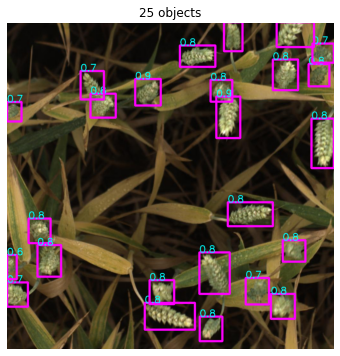

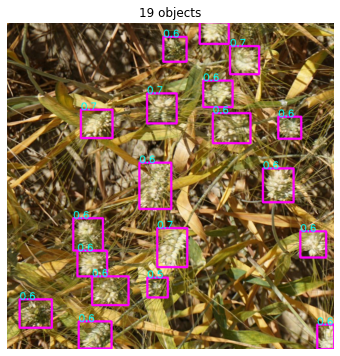

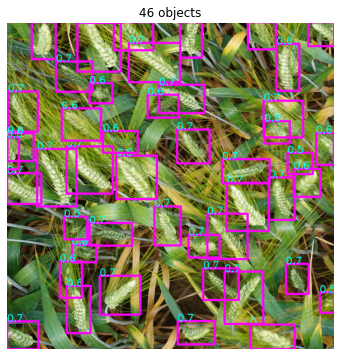

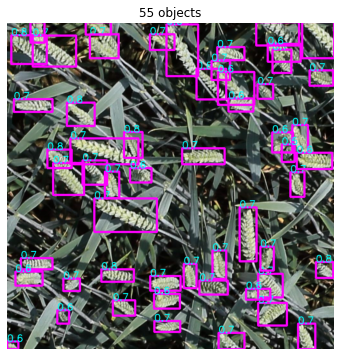

In [30]:
# Search for best ///ardışık norm SONUÇ
iou_thresholds, score_thresholds = [0.2, 0.35, 0.5], [0.3, 0.5, 0.7]
thresholds_comb = [(iou_threshold, score_threshold) for iou_threshold in iou_thresholds for score_threshold in score_thresholds]

valid_steps, mAP = min(VALID_STEPS_PER_EPOCH, 10), np.zeros((len(thresholds_comb)), np.float32)
for valid_step, (batch_x, (batch_regression, batch_classification)) in tqdm(enumerate(valid_dataset_encode)):
    if (valid_step + 1) > valid_steps:
        break
    obj_info_true = datasets_decode(batch_regression, batch_classification, iou_threshold=0.99, score_threshold=1.)
    obj_info_pred_list = datasets_predict(batch_x, thresholds_comb=thresholds_comb, tta = False)
    for threshold_idx, obj_info_pred in enumerate(obj_info_pred_list):
        mAP[threshold_idx] += metric_mAP(obj_info_true, obj_info_pred) / valid_steps
        
best_mAP_idx = np.argmax(mAP)
best_mAP, (best_iou_threshold, best_score_threshold) = mAP[best_mAP_idx], thresholds_comb[best_mAP_idx]
print("Best mAP: {0:.4f} iou: {1} score : {2}".format(best_mAP, best_iou_threshold, best_score_threshold))


for batch_x, _ in valid_dataset_encode:
    obj_info_pred = datasets_predict(batch_x, thresholds_comb=thresholds_comb[best_mAP_idx:None], tta = False)[0]
    visualize_decode(batch_x, obj_info_pred)
    break

Test on test datasets (TTA)

In [31]:
test_dir = '../input/global-wheat-detection/test/'
test_image_paths =  [os.path.join(test_dir, path) for path in os.listdir(test_dir)]

class batch_items:
    def __init__(self, paths, batch_size):
        self.group_paths = [paths[i : i + batch_size] for i in range(0, len(paths), batch_size)]
        self.group_ids = ["" for i in range(batch_size)] # (Batch Size)
        self.group_items = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), np.float32) # (Batch Size, H, W, 3)
        self.group_idx = 0

    def __iter__(self):
        return self
    
    def __next__(self):
        if(self.group_idx >= len(self.group_paths)):
            raise StopIteration
        paths = self.group_paths[self.group_idx]
        for idx in range(len(paths)):
            self.group_ids[idx] = os.path.basename(paths[idx]).split(".")[0]
            self.group_items[idx] = cv2.resize(cv2.cvtColor(cv2.imread(paths[idx]), cv2.COLOR_BGR2RGB), (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
        self.group_idx += 1
        return self.group_ids, self.group_items, len(paths)

sumbit_res = []
for batch_idxs, batch_imgs, batch_size in batch_items(test_image_paths, BATCH_SIZE):
    batch_obj_info = datasets_predict(batch_imgs, thresholds_comb=[[0.35, 0.5]], tta = True)[0]
    #visualize_decode(tf.convert_to_tensor(batch_imgs), batch_obj_info)
    for idx in range(batch_size):
        for elem in batch_obj_info[idx]:
            tx1, ty1, tx2, ty2, score, classes_idx = elem
            tw, th = tx2 - tx1, ty2 - ty1
            tx, ty = tx1 + tw / 2, ty1 + th / 2
            sumbit_res.append({
                'image_id': batch_idxs[idx],
                'PredictionString': "{0:.4f} {1} {2} {3} {4}".format(score, int(tx), int(ty), int(tw), int(th))
            })
    
test_df = pd.DataFrame(sumbit_res, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,796707dd7,0.7012 658 75 80 75
1,796707dd7,0.7025 949 378 106 87
2,796707dd7,0.7259 765 875 102 94
3,796707dd7,0.6874 550 836 88 100
4,796707dd7,0.6949 523 317 105 97
